In [55]:
# Cell 1: Import necessary libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense # type: ignore
import matplotlib.pyplot as plt


In [56]:
# Cell 2: Data Preparation
def generate_preference_score(row, user_preferred_industries, investment_horizon, max_change, min_change):
    score = 0.0

    if row["Industry"] in user_preferred_industries:
        score += 0.5

    if max_change != min_change:
        if investment_horizon == "Long-Term":
            normalized_change = (row["Change Since IPO (%)"] - min_change) / (max_change - min_change)
        else:  
            normalized_change = (row["1-Year Stock Price Change (%)"] - min_change) / (max_change - min_change)
    else:
        normalized_change = 0.5

    score += 0.5 * normalized_change
    return score

def prepare_data(user_preferred_industries, investment_horizon):
    df = pd.read_csv('stocks_data.csv')
    df["1-Year Stock Price Change (%)"] = pd.to_numeric(df["1-Year Stock Price Change (%)"], errors='coerce')
    df["Change Since IPO (%)"] = pd.to_numeric(df["Change Since IPO (%)"], errors='coerce')

    if investment_horizon == "Long-Term":
        max_change = df["Change Since IPO (%)"].max()
        min_change = df["Change Since IPO (%)"].min()
    else:
        max_change = df["1-Year Stock Price Change (%)"].max()
        min_change = df["1-Year Stock Price Change (%)"].min()

    df["Preference Score"] = df.apply(
        generate_preference_score,
        axis=1,
        args=(user_preferred_industries, investment_horizon, max_change, min_change)
    )

    return df


In [57]:
# Cell 3: Feature Engineering
def create_features(df, user_preferred_industries):
    industry_lb = LabelBinarizer()
    industry_encoded = industry_lb.fit_transform(df["Industry"])
    industry_df = pd.DataFrame(industry_encoded, columns=industry_lb.classes_)

    df = pd.concat([df.reset_index(drop=True), industry_df], axis=1)
    df.drop('Industry', axis=1, inplace=True)

    user_industries_encoded = industry_lb.transform(user_preferred_industries)
    user_industry_vector = np.max(user_industries_encoded, axis=0)

    user_preferences_df = pd.DataFrame([user_industry_vector] * len(df), columns=industry_lb.classes_)
    user_preferences_df.reset_index(drop=True, inplace=True)

    company_features = df[["1-Year Stock Price Change (%)", "Change Since IPO (%)"] + list(industry_lb.classes_)]
    X = pd.concat([company_features.reset_index(drop=True), user_preferences_df], axis=1)
    y = df["Preference Score"]

    return X, y, industry_lb


In [58]:
# Cell 4: Model Training
def train_model(X, y):
    X = X.values
    y = y.values

    scaler = MinMaxScaler()
    X[:, :2] = scaler.fit_transform(X[:, :2])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = Sequential([
        Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')
    history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

    return model, history, scaler


In [ ]:
# Cell 5: Model Evaluation
def evaluate_model(model, X_test, y_test):
    loss = model.evaluate(X_test, y_test)
    print(f'Test Loss: {loss}')
    
   


In [60]:
def get_preference_score(model, scaler, df, company_name, user_preferred_industries, investment_horizon, industry_lb):
    # Prepare user preferences
    user_industries_encoded = industry_lb.transform(user_preferred_industries)
    user_industry_vector = np.max(user_industries_encoded, axis=0)
    user_preferences = pd.DataFrame([user_industry_vector], columns=industry_lb.classes_)

    # Find the company
    company_row = df[df["Company Name"] == company_name]

    if company_row.empty:
        print("Company not found.")
        return None

    # Add missing columns to match industry_lb.classes_
    missing_columns = set(industry_lb.classes_) - set(company_row.columns)
    for col in missing_columns:
        company_row[col] = 0

    # Prepare company features
    company_features = company_row[["1-Year Stock Price Change (%)", "Change Since IPO (%)"] + list(industry_lb.classes_)]
    
    # Scale numerical features
    numerical_features = company_features[["1-Year Stock Price Change (%)", "Change Since IPO (%)"]].values
    numerical_features = scaler.transform(numerical_features)
    company_features[["1-Year Stock Price Change (%)", "Change Since IPO (%)"]] = numerical_features

    # Combine features
    input_features = pd.concat([company_features.reset_index(drop=True), user_preferences.reset_index(drop=True)], axis=1)
    input_features = input_features.values

    # Predict preference score
    preference_score = model.predict(input_features)[0][0]
    return preference_score


In [61]:
# Cell 7: Main Workflow

# Define user preferences
user_preferred_industries = ["Technology", "Financial Services"]
investment_horizon = "Long-Term"

# Step 1: Prepare the data
df = prepare_data(user_preferred_industries, investment_horizon)

# Step 2: Create features and labels
X, y, industry_lb = create_features(df, user_preferred_industries)

# Debugging Step: Print columns of df to verify industry columns are included
print("Columns after feature engineering:", df.columns)

# Step 3: Train the model
model, history, scaler = train_model(X, y)

# Step 4: Evaluate Model
X_test = X.values
y_test = y.values
evaluate_model(model, X_test, y_test)

# Step 5: Use the Utility Function to Predict Preference Score
company_name = "Alphabet (Google)"
preference_score = get_preference_score(model, scaler, df, company_name, user_preferred_industries, investment_horizon, industry_lb)
print(f"Preference Score for {company_name}: {preference_score:.2f}")


Columns after feature engineering: Index(['Company Name', 'Stock Symbol', 'Industry', 'Exchange',
       '1-Year Stock Price Change (%)', 'Change Since IPO (%)',
       'Preference Score'],
      dtype='object')


c:\Users\jy3df\OneDrive\Documents\hackutd_dataset\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.1587 - val_loss: 0.1406
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1440 - val_loss: 0.1326
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1377 - val_loss: 0.1243
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1202 - val_loss: 0.1151
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1107 - val_loss: 0.1050
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0983 - val_loss: 0.0949
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0894 - val_loss: 0.0851
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0757 - val_loss: 0.0759
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0668 - val_loss: 0.0676
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0584 - val_loss: 0.0610
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0519 - val_loss: 0.0552
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0432 - val_loss: 0.0504
Epo

C:\Users\jy3df\AppData\Local\Temp\ipykernel_39748\194192549.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_row[col] = 0
C:\Users\jy3df\AppData\Local\Temp\ipykernel_39748\194192549.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_row[col] = 0
C:\Users\jy3df\AppData\Local\Temp\ipykernel_39748\194192549.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

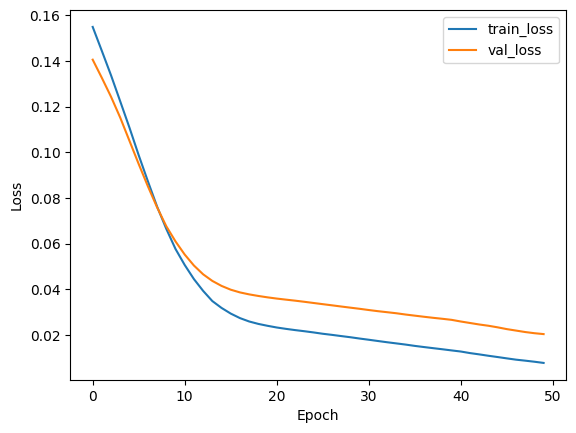

In [62]:
# Cell 8: Plotting Training History
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
